# Snowflake Data Exploration

The goal of this notebook is to support the design of a research hypothesis suitable for the CRM Data Cloud.

In [135]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,datetime,time,math,itertools,os,sys

import torch
import torch.nn as nn
from torch.nn import functional as F

import pandas as pd
import plotly.express as px

from sklearn.preprocessing import LabelEncoder

import networkx as nx

import snowflake.connector

In [2]:
sys.path.append('./../7_HELPERFUNCTIONS/')
from WorldSimulators.CRMDatabase import CRMDB

## Fetch DB information

Build connection framework for pulling data from Snowflake. Fetch Metadata Information.

In [3]:
conn = snowflake.connector.connect(
    user='jan-lucas.deinhard@siemens-healthineers.com',
    account='shsitdl.west-europe.azure',
    authenticator='externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [4]:
# CRM Data Cloud Metadata
info = pd.read_sql("SHOW COLUMNS",con=conn)

In [5]:
conn.close()

## Instantiate CRM Data Base from class

Get the CRM Database class and populate. Dig into the structure.

In [6]:
db = CRMDB()

## Summarize data into characteristic vector

Create a summary vector v for every DB row, excluding key elements. Examine data frames based only on keys and characteristic vectors.

In [7]:
# Iterate DB frames as an example to generate encoded characteristic vector

for cframe in db.frames.keys():
    # Select current frame
    tdf_init = db.frames[cframe]
    tdf = db.frames[cframe].copy()
    # Iterate over non-key columns in current frame
    for ccol in tdf[[k for k in tdf.columns.tolist() if k not in db.metadata[db.metadata['ISKEY']=='Y'].COLUMN.tolist()]].select_dtypes(include='object').columns:
        lenc = LabelEncoder() 
        tdf[ccol] = lenc.fit_transform(tdf[ccol])
    # Store full vector as new frame entry
    tdf_init['v'] = tdf[[k for k in tdf.columns.tolist() if k not in db.metadata[db.metadata['ISKEY']=='Y'].COLUMN.tolist()]].apply(lambda x: x.values,axis=1)

In [8]:
# Make list of included columns for Accounts -> Keys and characteristic vector
L = [k for k in db.frames['Accounts'].columns.tolist() if k in db.metadata[db.metadata['ISKEY']=='Y'].COLUMN.tolist()]
L.append('v')

# Fetch Accounts data frame as an example
df = db.frames['Accounts'][L]

## Explore characteristic vector

PCA decomposition of characteristic vector - visualize important components!

In [57]:
# Use PCA from python
from sklearn.decomposition import PCA

In [124]:
# Make a 4-dim PCA decomposition

pca = PCA(n_components=4)
pca_transformed = pca.fit_transform(np.stack(df['v'].values))

#### Explained Variance of 4-dimensional PCA:

In [58]:
pca.explained_variance_ratio_.sum()

0.9222555602332428

#### Visualize which original features contribute most to PCA components: 

In [91]:
cols = db.frames['Accounts'][
    [k for k in db.frames['Accounts'].columns.tolist() if k not in db.metadata[db.metadata['ISKEY']=='Y'].COLUMN.tolist() and k!='v']
].columns

In [106]:
n_pcadim,n_featuredim = pca.components_.shape

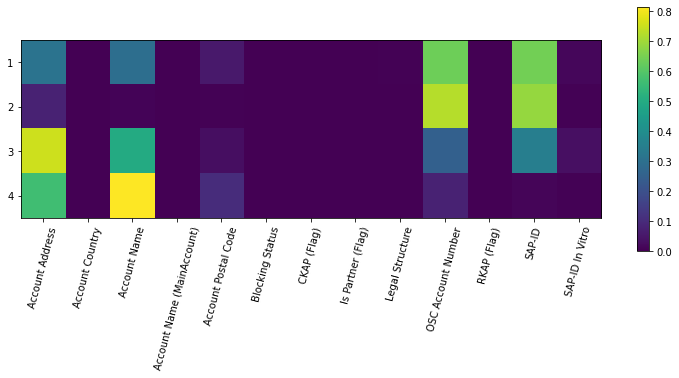

In [128]:
fig = plt.figure(figsize=(13,9))

im = plt.imshow(np.abs(pca.components_))
plt.xticks(np.arange(n_featuredim),cols,rotation=75)
plt.yticks(np.arange(n_pcadim),np.arange(n_pcadim)+1)

plt.colorbar(im,shrink=0.5)

plt.show()

## Preliminary Conclusion - Important Dimensions

The chatracteristic vector looks like it encodes effectively the important dimensions. Next step is to build this visualization into the CRM DB entity, perform for all tables and use it to visualize. Before doing that, let's test in three dimensions and visualize the actual data:

In [132]:
pca3d = PCA(n_components=3)
pca_transformed3d = pca3d.fit_transform(np.stack(df['v'].values))

#### Explained Variance of 3-dimensional PCA:

In [133]:
pca3d.explained_variance_ratio_.sum()

0.7598393613906553

#### 3-dim transformed components, visualized:

In [138]:
fig = px.scatter_3d(
    pd.DataFrame(pca_transformed3d).rename(columns={
        0:'PCA1',
        1:'PCA2',
        2:'PCA3'
    }),
    x='PCA1',
    y='PCA2',
    z='PCA3'
)
fig.show()